# OSU Micro Benchmarks (OMB)

Results of selected latency and bandwidth tests from the [OMB suite](http://mvapich.cse.ohio-state.edu/benchmarks/).

All these tests use two nodes:

- `osu_bw`: Single process per node
- `osu_latency`: Single process per node
- `osu_bibw` (bidirectional bandwidth test): Single process per node
- `osu_allgather`, `osu_allreduce`, `osu_alltoall` (MPI blocking collective tests): As many processes per node as physical cores
- `osu_mbw_mr` (multiple bandwidth / message rate test): Varying numbers of processes per node, communicating in pairs split across nodes

In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Single process per node: Bandwidth & latency vs message size

The plots below show results vs message size for tests using a single process per node. Results are for the most-recent test on each system/partition/environment combination.

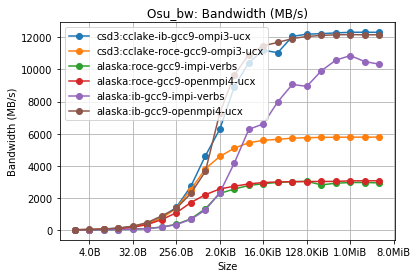

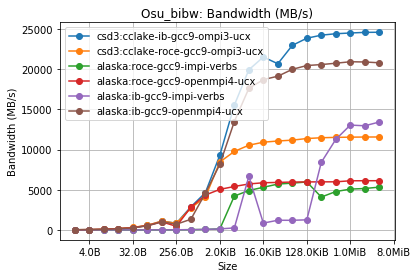

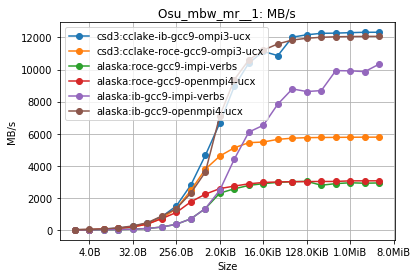

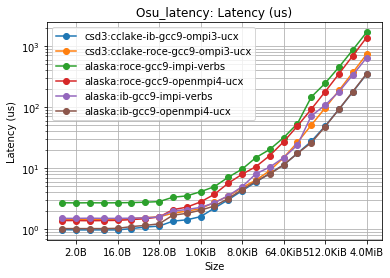

In [2]:
for test in ['Osu_bw', 'Osu_bibw',
             'Osu_mbw_mr__1', # -1 to specify 1x process/node => "_1" in reframe test title
             'Osu_latency']:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.omb.read_omb_out(path)
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        plt.plot(data.columns[0], data.columns[1], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    if 'latency' in data.columns[1].lower():
        ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel(data.columns[0])
    ax.set_ylabel(data.columns[1])
    ax.set_title('%s: %s' % (test, data.columns[1]))
    ax.legend()

# MPI Blocking Collective  Operations: Latency vs message size

The plots below show results vs message size for tests using as many processes per nodes as there are physical cores. Results are for the most-recent test on each system/partition/environment combination.

Values are the mean latency for each message size taken over all pairs of communicating processes.

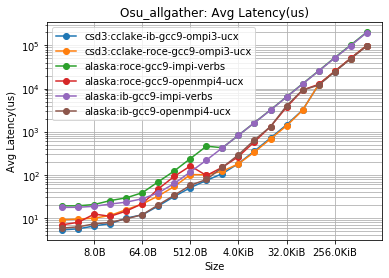

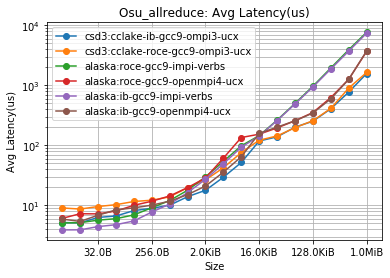

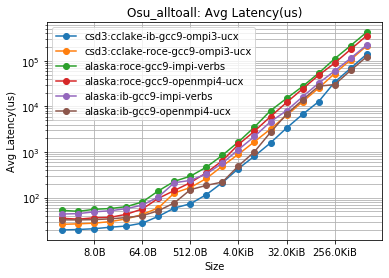

In [3]:
for test in  ['Osu_allgather', 'Osu_allreduce', 'Osu_alltoall', ]:
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.omb.read_omb_out(path)
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        plt.plot(data.columns[0], data.columns[1], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel(data.columns[0])
    ax.set_ylabel(data.columns[1])
    ax.set_title('%s: %s' % (test, data.columns[1]))
    ax.legend()

# Max Bandwidth/Message Rate vs Number of Processes per Node

The plots below show the **maximum** bandwidth and message rate for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

max_bandwidth: Osu_mbw_mr_*


case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-roce-gcc9-ompi3-ucx
procs_per_node,,,,,,
1,10896.91,12069.25,3031.65,3063.10,12324.82,5785.24
2,12180.14,12392.64,3088.67,3063.59,12637.00,5787.06
4,12515.17,12075.90,3073.99,3063.72,12344.86,5786.15
8,12450.14,12392.77,3066.47,3063.63,12343.09,5786.21
16,12413.78,12392.76,3065.01,3063.62,12345.60,5786.41
32,12400.55,12050.50,3064.32,3063.56,12227.03,5664.28
56,NaN,NaN,NaN,NaN,12297.38,5673.16


max_message_rate: Osu_mbw_mr_*


case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-roce-gcc9-ompi3-ucx
procs_per_node,,,,,,
1,1384873.02,8.015239e+06,1446393.31,5766872.38,7.193154e+06,6056013.42
2,2707093.62,1.464903e+07,2722545.17,10425396.92,1.126064e+07,10740300.50
4,5343849.78,2.902595e+07,5397445.24,25012212.99,2.688320e+07,23436039.32
8,10124744.63,5.534562e+07,10599057.58,32883898.64,5.189702e+07,47196395.65
16,21352231.61,1.013383e+08,20584857.98,32990241.40,1.000838e+08,59637700.63
32,41975222.67,8.133890e+07,20851263.07,32900439.40,8.010808e+07,51379201.46
56,NaN,NaN,NaN,NaN,7.025248e+07,32743693.15


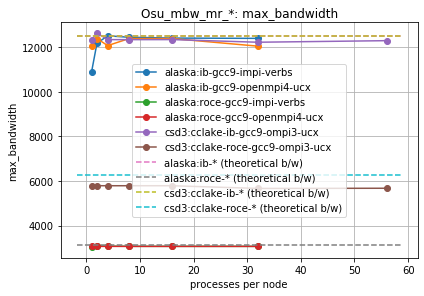

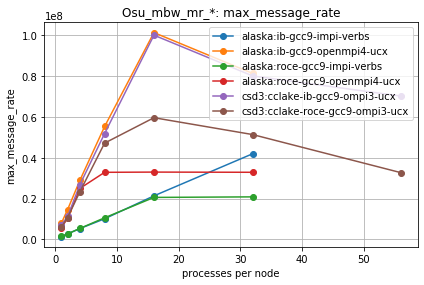

In [4]:
# TODO: needs to be loaded from system config somewhere
Gb_to_MB = 125.0

test = 'Osu_mbw_mr_*'
    
for perf_var in ['max_bandwidth', 'max_message_rate']:
    
    # get, plot and tabulate data:
    df = modules.utils.tabulate_last_perf(test, 'procs_per_node', perf_var)
    print('%s: %s' % (perf_var, test))
    display(HTML(df.to_html()))
    ax = df.plot(grid=True, style='o-')
    
    # add max bandwidth to relevant plots:
    if 'bandwidth' in perf_var:
        xlim = ax.get_xlim()
        for syspart, bw in modules.utils.get_sys_param('interconnect_Gb').items():
            theoretical_bw_MB = bw * Gb_to_MB
            label = syspart + " (theoretical b/w)"
            ax.plot(xlim, [theoretical_bw_MB, theoretical_bw_MB], '--', label=label)
    # format:
    ax.set_xlabel('processes per node')
    ax.set_ylabel(perf_var)
    plt.tight_layout()
    ax.set_title('%s: %s' % (test, perf_var))
    ax.legend()
